<a href="https://colab.research.google.com/github/sergiogf93/MetNumerics/blob/master/notebooks/06_ODEs_IVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt

# Solucions numèriques a problemes EDO de valor inicial

Molts sistemes físics, biològics i socials es poden escriure com un sistema d'equacions diferencials ordinàries (EDOs). En els casos on l'estat (valor) inicial és conegut el problema es pot escriure com

$$
    \frac{\text{d} \vec{\!u}}{\text{d}t} = \vec{\!f}(t, \vec{\!u}) \quad \vec{\!u}(0) = \vec{\!u}_0
$$

on

 - $\vec{\!u}(t)$ és el vector estat
 - $\vec{\!f}(t, \vec{\!u})$ és una funció que controla el canvi de $\vec{\!u}$ amb el temps
 - $\vec{\!u}(0)$ és la condició inicial en el tems $t = 0$

#### Exemples: Desintegració radioactiva simple

$$
    \vec{\!u} = [c]
$$
   
$$
    \frac{\text{d} c}{\text{d}t} = \lambda c \quad c(0) = c_0
$$
   

les solucions tenen la forma $c(t) = c_0 e^{\lambda t}$

In [0]:
t = numpy.linspace(0.0, 1.6e3, 100)
c_0 = 1.0
decay_constant = -numpy.log(2.0) / 1600.0

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, 1.0 * numpy.exp(decay_constant * t))

axes.set_title("Radioactive Decay with $t_{1/2} = 1600$ years")
axes.set_xlabel('t (years)')
axes.set_ylabel('$c$')
axes.set_xlim((0.0, 1650))
axes.set_ylim((0.5,1.0))
plt.show()

#### Exemples:  Desintegració radioactiva complexa (o sistema químic).

Cadenes de desintegracions d'una espècie a una altra.

$$\begin{aligned}
    \frac{\text{d} c_1}{\text{d}t} &= -\lambda_1 c_1 \\
    \frac{\text{d} c_2}{\text{d}t} &= \lambda_1 c_1 - \lambda_2 c_2 \\
    \frac{\text{d} c_3}{\text{d}t} &= \lambda_2 c_2 - \lambda_3 c_3 
\end{aligned}$$

$$\frac{\text{d} \vec{\!u}}{\text{d}t} = \frac{\text{d}}{\text{d}t}\begin{bmatrix} c_1 \\ c_2 \\ c_3 \end{bmatrix} = 
\begin{bmatrix} 
    -\lambda_1 & 0 & 0 \\
    \lambda_1 & -\lambda_2 & 0 \\
    0 & \lambda_2 & -\lambda_3
\end{bmatrix} \begin{bmatrix} c_1 \\ c_2 \\ c_3 \end{bmatrix}$$

$$\frac{\text{d} \vec{\!u}}{\text{d}t} = A \vec{\!u}$$

Per sistemes d'equacions com aquests la solució general de l'EDO és la matriu exponencial:

$$\vec{\!u}(t) = \vec{\!u}_0 e^{A t}$$

#### Exemples: Seguiment d'una partícula en un fluid

$$\frac{\text{d} \vec{\!X}}{\text{d}t} = \vec{\!V}(t, \vec{\!X})$$

The fet tot problema d'EDOs de valors inicial es pot pensar com el seguiment d'una partícula dins camp de flux (sistema dinàmic). En 1-dimensió el flux és determinat per la condició inicial.

#### Exemple: Oscil·lador de Van der Pol

$$y'' - \mu (1 - y^2) y' + y = 0 \quad \quad \text{with} \quad \quad  y(0) = y_0, \quad y'(0) = v_0$$
 
$$\vec{\!u} = \begin{bmatrix} y \\ y' \end{bmatrix} = \begin{bmatrix} u_1 \\ u_2 \end{bmatrix}$$
   
$$\frac{\text{d}}{\text{d}t} \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} = \begin{bmatrix} u_2 \\ \mu (1 - u_1^2) u_2 - u_1 \end{bmatrix} = \vec{\!f}(t, \vec{\!u})$$

In [0]:
?integrator.integrate

In [0]:
import scipy.integrate as integrate

def f(t, u, mu=5):
    return numpy.array([u[1], mu * (1.0 - u[0]**2) * u[1] - u[0]])

# N = 100
N = 500
# N = 1000
t = numpy.linspace(0.0, 100, N)
u = numpy.empty((2, N))
u[:, 0] = [0.1, 0.0]

integrator = integrate.ode(f)
integrator.set_integrator("dopri5")
integrator.set_initial_value(u[:, 0])

for (n, t_n) in enumerate(t[1:]):
    integrator.integrate(t_n)
    if not integrator.successful():
        break
    u[:, n + 1] = integrator.y
    
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(t, u[0,:])
axes.set_title("Solution to Van der Pol Oscillator")
axes.set_xlabel("t")
axes.set_ylabel("y(t)")

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(u[0,:], u[1, :])
axes.plot(u[0,:], u[1, :], 'ro')
axes.set_title("Phase Diagram for Van der Pol Oscillator")
axes.set_xlabel("y(t)")
axes.set_ylabel("y '(t)")

plt.show()

## Esquèmes bàsics

Introduïm notació per simplificar les coses

$$\begin{aligned}
    t_0 &= 0 \\
    t_1 &= t_0 + \Delta t \\
    t_n &= t_{n-1} + \Delta t = n \Delta t + t_0 \\
    u_0 &= u(t_0) \approx U_0 \\
    u_1 &= u(t_1) \approx U_1 \\
    u_n &= u(t_n) \approx U_2 \\
\end{aligned}$$

on les lletres en minúscula són "exactes".

Mirant el que hem fet en la diferenciació numèrica; per què no aproximar la derivada com la diferència finita:

$$
    \frac{u(t + \Delta t) - u(t)}{\Delta t} = f(t, u)
$$

Encara hem de decidir com evaluar el terme $f(t,u)$ però.

Considerem-ho desde la perspectiva de la quadratura, prenem la integral pels dos costats de la igualtat:

$$\begin{aligned}
    \int^{t + \Delta t}_t \frac{\text{d} u}{\text{d}\tilde{\!t}} d\tilde{\!t} &= \int^{t + \Delta t}_t f(t, u) d\tilde{\!t} \\
    u(t + \Delta t) - u(t) &\approx \Delta t f(t, u(t))
\end{aligned}$$



Podem reescriure l'esquema
$$
    u(t + \Delta t) - u(t) = \Delta t f(t, u(t))
$$
com
$$
    \frac{U_{n+1} - U_n}{\Delta t} = f(t_n, U_n)
$$
o bé
$$
    U_{n+1} = U_n + \Delta t f(t_n, U_n)
$$

conegut com el *mètode forward d'Euler*. En essència estem aproximant la derivada amb el valor de la funció on estem a $t_n$.

In [0]:
t = numpy.linspace(0.0, 1.6e3, 100)
c_0 = 1.0
decay_constant = -numpy.log(2.0) / 1600.0

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, c_0 * numpy.exp(decay_constant * t), label="True Solution")

# Plot Euler step
dt = 1e3
u_np = c_0 + dt * (decay_constant * c_0)
axes.plot((0.0, dt), (c_0, u_np), 'k')
axes.plot((dt, dt), (u_np, c_0 * numpy.exp(decay_constant * dt)), 'k--')
axes.plot((0.0, 0.0), (c_0, u_np), 'k--')
axes.plot((0.0, dt), (u_np, u_np), 'k--')
axes.text(400, u_np - 0.05, '$\Delta t$', fontsize=16)

axes.set_title("Radioactive Decay with $t_{1/2} = 1600$ years")
axes.set_xlabel('t (years)')
axes.set_ylabel('$c$')
axes.set_xlim(-1e2, 1.6e3)
axes.set_ylim((0.5,1.0))
axes.legend(loc='best')
plt.show()

#### Exercici

Implementa el mètode forward d'Euler per aproximar la solució de:

$$
  f(t,u) = \frac{du}{dt} = \lambda u
$$


Utilitza $u(t=0) = 1$ com a valor inicial i $\lambda = -\ln(2)/1600$ com a constant de desintegració.

Considera només 10 punts en l'interval [0,1600]. Compara amb la solució real $u(t)=c_0 e^{\lambda t}$



In [0]:
N = 10
c_0 = 1.0
decay_constant = -numpy.log(2.0) / 1600.0
f = lambda t, u: decay_constant * u

# Els nostres temps on avaluar la funció són
t_exact = numpy.linspace(0.0, 1.6e3, 100)
# u_exact = ...

# Implementa el mètode forward d'Euler
t_euler = numpy.linspace(0.0, 1.6e3, N)
# u_euler = ...
#
#


# Fes un plot comparant u_exact amb u_euler en funció del temps

In [0]:
#@title
N = 10
c_0 = 1.0
decay_constant = -numpy.log(2.0) / 1600.0
f = lambda t, u: decay_constant * u

t_exact = numpy.linspace(0.0, 1.6e3, 100)
u_exact = c_0 * numpy.exp(decay_constant * t_exact)

# Implement Forward Euler
t_euler = numpy.linspace(0.0, 1.6e3, N)
delta_t = t_euler[1] - t_euler[0]
u_euler = numpy.empty(t_euler.shape)
u_euler[0] = c_0
for (n, t_n) in enumerate(t_euler[:-1]):
    u_euler[n + 1] = u_euler[n] + delta_t * f(t_n, u_euler[n])

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t_euler, u_euler, 'or', label="Euler")
axes.plot(t_exact, u_exact, 'k--', label="True Solution")

axes.set_title("Forward Euler")
axes.set_xlabel("t (years)")
axes.set_ylabel("$c(t)$")
axes.set_ylim((0.4,1.1))
axes.legend()
plt.show()

Un mètode similar pot ser derivat si considerem la diferència centrada

$$\frac{U_{n+1} - U_{n-1}}{2\Delta t} = f(t_{n}, U_{n})$$

aquest mètode és conegut com `leap-frog method`. Noteu que s'utilitza una evaluació prèvia de la funció.

Vegeu que per trobar $U_1$ caldria tenir $U_{-1}$, que no té sentit en el problema. El procediment a seguir és calcular $U_1$ amb el mètode d'Euler i després calcular la resta d'$U_n$ per $n>1$ amb l'equació anterior. Així doncs, l'algoritme queda:

$$\begin{aligned}
  U_0 &= c_0 \\
  U_1 &= U_0 + \Delta t f(t_0,U_0) \\
  U_{n+1} &= U_{n-1} + 2 \Delta t f(t_n,U_n)
\end{aligned}
$$


#### Exercici

Implementa el mètode 'leap-frog' per aproximar

$$
  f(t,u) = \frac{du}{dt} = \lambda u
$$

Utilitza $u(t=0) = 1$ com a valor inicial i $\lambda = -\ln(2)/1600$ com a constant de desintegració.

Considera només 10 punts en l'interval [0,1600]. Compara amb la solució real $u(t)=c_0 e^{\lambda t}$

In [0]:
c_0 = 1.0
decay_constant = -numpy.log(2.0) / 1600.0
f = lambda t, u: decay_constant * u

# Els nostres temps on avaluar la funció són
t_exact = numpy.linspace(0.0, 1.6e3, 100)
# u_exact = ...

# Implementa el mètode leap-frog
t_leapfrog = numpy.linspace(0.0, 1.6e3, 25)
# u_leapfrog = ...
#
#


# Fes un plot comparant u_exact amb u_leapfrog en funció del temps

In [0]:
#@title
c_0 = 1.0
N = 10

# Stable example
decay_constant = -numpy.log(2.0) / 1600.0
t_exact = numpy.linspace(0.0, 1.6e3, 100)
t_leapfrog = numpy.linspace(0.0, 1.6e3, N)

# Unstable example
# decay_constant = -1.0
# t_exact = numpy.linspace(0.0, 5.0, 100)
# t_leapfrog = numpy.linspace(0.0, 5.0, N)

f = lambda t, u: decay_constant * u


u_exact = c_0 * numpy.exp(decay_constant * t_exact)

# Implement leap-frog
delta_t = t_leapfrog[1] - t_leapfrog[0]
u_leapfrog = numpy.empty(t_leapfrog.shape)
u_leapfrog[0] = c_0
u_leapfrog[1] = u_leapfrog[0] + delta_t * f(t_leapfrog[0], u_leapfrog[0])
for n in range(1, t_leapfrog.shape[0] - 1):
    u_leapfrog[n + 1] = u_leapfrog[n - 1] + 2.0 * delta_t * f(t_leapfrog[n], u_leapfrog[n])

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t_leapfrog, u_leapfrog, 'or-', label="Leap-Frog")
axes.plot(t_exact, u_exact, 'k--', label="True Solution")

axes.set_title("Leap-Frog")
axes.set_xlabel("t (years)")
axes.set_xlabel("$c(t)$")
axes.legend()
plt.show()

Similarment al mètode forward d'Euler hi ha el mètode *backward d'Euler*. Com podeu imaginar, evalua la funció $f$ de la manera següent:

$$
    U_{n+1} = U_n + \Delta t f(t_{n+1}, U_{n+1}).
$$

Els esquemes on la funció $f$ és avaluada al temps desconegut s'anomenen *mètodes implícits*.

En alguns casos podem resoldre l'equació des del principi. Per exemple, en el nostre cas de desintegració tenim:

$$
    U_{n+1} = U_n + \Delta t f(t_{n+1}, U_{n+1}) = U_n + \Delta t (\lambda U_{n+1})
$$

que podem resoldre per $U_{n+1}$ i trobem

$$\begin{aligned}
    U_{n+1} &= U_n + \Delta t (\lambda U_{n+1}) \\
    U_{n+1} \left[ 1 - \Delta t \lambda \right ] &= U_n \\
    U_{n+1} &= \frac{U_n}{1 - \Delta t \lambda}
\end{aligned}$$

També és útil poder fer això en casos de sistemes d'EDOs. Diguem $f(U) = A U$, llavors


$$\begin{aligned}
    U_{n+1} &= U_n + \Delta t (A U_{n+1}) \\
    U_{n+1} \left [ I - \Delta t A \right ] &= U_n \\
    U_{n+1} &= \left [ I - \Delta t A \right]^{-1} U_n
\end{aligned}$$

En general, però, això no ho podrem fer per una $f$ arbitrària.

#### Exercici

Implementa el mètode barckward d'Euler per aproximar

$$
  f(t,u) = \frac{du}{dt} = \lambda u
$$

Compara el resultat amb la solució real $u(t) = c_0 e^{\lambda t}$

Utilitza $u(t=0) = 1$ com a valor inicial i $\lambda = -\ln(2)/1600$ com a constant de desintegració.


In [0]:
c_0 = 1.0
decay_constant = -numpy.log(2.0) / 1600.0
f = lambda t, u: decay_constant * u

# Els nostres temps on avaluar la funció són
t_exact = numpy.linspace(0.0, 1.6e3, 100)
# u_exact = ...

# Implementa el mètode backward d'Euler
t_backwards = numpy.linspace(0.0, 1.6e3, 10)
# u_backwards = ...
#
#


# Fes un plot comparant u_exact amb u_backwards en funció del temps

In [0]:
#@title
c_0 = 1.0
decay_constant = -numpy.log(2.0) / 1600.0
f = lambda t, u: decay_constant * u

t_exact = numpy.linspace(0.0, 1.6e3, 100)
u_exact = c_0 * numpy.exp(decay_constant * t_exact)

# Implement backwards Euler
t_backwards = numpy.linspace(0.0, 1.6e3, 10)
delta_t = t_backwards[1] - t_backwards[0]
u_backwards = numpy.empty(t_backwards.shape)
u_backwards[0] = c_0
for n in range(0, t_backwards.shape[0] - 1):
    u_backwards[n + 1] = u_backwards[n] / (1.0 - decay_constant * delta_t)

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t_backwards, u_backwards, 'or', label="Backwards Euler")
axes.plot(t_exact, u_exact, 'k--', label="True Solution")

axes.set_title("Backwards Euler")
axes.set_xlabel("t (years)")
axes.set_xlabel("$c(t)$")
axes.set_ylim((0.4,1.1))
axes.legend()
plt.show()

Un altre mètode implícit està basat en l'integració a partir del mètode trapezial. L'esquema és

$$
    \frac{U_{n+1} - U_{n}}{\Delta t} = \frac{1}{2} (f(U_n) + f(U_{n+1}))
$$

Quin és en aquest cas l'esquema d'actualització?

$$\begin{aligned}
    U_{n+1} &= U_{n} + \frac{\Delta t}{2} (f(U_n) + f(U_{n+1})) \\
    U_{n+1} &= U_{n} + \frac{\Delta t}{2} (\lambda U_n + \lambda U_{n+1}) \\
    U_{n+1} \left[1 - \frac{\Delta t \lambda}{2}  \right] &= U_{n} \left[1 + \frac{\Delta t \lambda}{2} \right] \\
    U_{n+1} &= U_{n} \frac{1 + \frac{\Delta t \lambda}{2}}{1 - \frac{\Delta t \lambda}{2}} \\
\end{aligned}$$

#### Exercici

Implementa el mètode trapezial per aproximar

$$
  f(t,u) = \frac{du}{dt} = \lambda u
$$

Compara el resultat amb la solució real $u(t) = c_0 e^{\lambda t}$

Utilitza $u(t=0) = 1$ com a valor inicial i $\lambda = -\ln(2)/1600$ com a constant de desintegració.


In [0]:
c_0 = 1.0
decay_constant = -numpy.log(2.0) / 1600.0
t_exact = numpy.linspace(0.0, 1.6e3, 100)
u_exact = c_0 * numpy.exp(decay_constant * t_exact)

#Implementa el mètode trapezial
t = numpy.linspace(0.0, 1.6e3, 10)
delta_t = t[1] - t[0]
u = numpy.empty(t.shape)
u[0] = c_0
#
#
#

# Compara u_exact i u en funció del temps

In [0]:
#@title
c_0 = 1.0
decay_constant = -numpy.log(2.0) / 1600.0
t_exact = numpy.linspace(0.0, 1.6e3, 100)
u_exact = c_0 * numpy.exp(decay_constant * t_exact)

# Implement trapezoidal method
t = numpy.linspace(0.0, 1.6e3, 10)
delta_t = t[1] - t[0]
u = numpy.empty(t.shape)
u[0] = c_0
integration_constant = (1.0 + decay_constant * delta_t / 2.0) / (1.0 - decay_constant * delta_t / 2.0)
for n in range(t.shape[0] - 1):
    u[n + 1] = u[n] * integration_constant

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, u, 'or', label="Trapezoidal")
axes.plot(t_exact, u_exact, 'k--', label="True Solution")

axes.set_title("Trapezoidal")
axes.set_xlabel("t (years)")
axes.set_xlabel("$c(t)$")
axes.set_ylim((0.4,1.1))
axes.legend()
plt.show()

## Anàlisi d'errors per mètodes d'EDO

Primer introduim més notació per poder distingir entre la solució de l'EDO $u(t_n)$ i el valor aproximat que denotarem $U_n$.

**Definició:** Definim *l'error de truncament* d'un esquema canviant $U_n$ amb la solució real $u(t_n)$ a la fórmula de les diferències finites i considerant la diferència amb la solució exacte.

Per exemple, pel mètode forward d'Euler
$$
    \frac{U_{n+1} - U_n}{\Delta t} = f(t_n,u_n)
$$
i definim l'error de truncament com
$$
    T(t, u; \Delta t) = \frac{u(t_{n+1}) - u(t_n)}{\Delta t} - f(t_n, u(t_n)).
$$

**Definició:** Un mètode és *consistent* si 
$$
    \lim_{\Delta t \rightarrow 0} T(t, u; \Delta t) = 0.
$$

**Definició:** Diem que un mètode té *ordre* $p$ en precisió si

$$
    \lVert T(t, u; \Delta t) \rVert \leq C \Delta t^p
$$

uniformement per $t \in [0, T]$. Ho podem escriure com $T(t, u; \Delta t) = \mathcal{O}(\Delta t^p)$. Noteu que un mètode és consistent si $p > 0$.

### Anàlisi d'error per Forward Euler

Podem analitzar l'error i l'ordre de convergència de forward Euler si considerem la sèrie de Taylor centrada a $t_n$:
$$
    u(t) = u(t_n) + (t - t_n) u'(t_n) + \frac{u''(t_n)}{2} (t - t_n)^2 + \mathcal{O}((t-t_n)^3)
$$

Avaluant la sèrie a $t_{n+1}$ dóna
$$\begin{aligned}
    u(t_{n+1}) &= u(t_n) + (t_{n+1} - t_n) u'(t_n) + \frac{u''(t_n)}{2} (t_{n+1} - t_n)^2 + \mathcal{O}((t_{n+1}-t_n)^3)\\
    &=u_n + \Delta t f(t_n, u_n) + \frac{u''(t_n)}{2} \Delta t^2 + \mathcal{O}(\Delta t^3)
\end{aligned}$$

Si prenem la diferència finita del mètode forward d'Euler
$$
    \frac{U_{n+1} - U_n}{\Delta t} = f(t_n)
$$
i substituim la formulació derivativa amb $u(t_n)$ trobem
$$\begin{aligned}
    T(t, u; \Delta t) &= \frac{u(t_{n+1}) - u(t_n)}{\Delta t} - f(t_n) \\
    &= \frac{u(t_{n+1}) - u(t_n)}{\Delta t} - u'(t_n).
\end{aligned}$$

Ara utilitzem la sèrie de Taylor centrada a $t_n$ i avaluada a $t_{n+1}$ per trobar

$$\begin{aligned}
    T(t, u; \Delta t) &= \frac{u(t_{n+1}) - u(t_n)}{\Delta t} - u'(t_n) \\
    &= \frac{1}{\Delta t} \left[ u(t_n) + u'(t_n) (t - t_n) + \frac{u''(t_n)}{2} (t - t_n)^2 + \mathcal{O}((t-t_n)^3) - u(t_n) \right] - u'(t_n) \\
    &=  u'(t_n) + \frac{u''(t_n)}{2} \Delta t + \mathcal{O}(\Delta t^2) - u'(t_n) \\
    &= \frac{u''(t_n)}{2} \Delta t + \mathcal{O}(\Delta t^2).
\end{aligned}$$

Que implica que el mètode forward d'Euler és de primer ordre de precisió i per tant és consistent.

Una altra definició equivalent de l'error de truncament fa servir la forma
$$
    U_{n+1} = u(t_n) + \Delta t f(t_n)
$$
i la definició
$$
    T(t, u; \Delta t) = \frac{1}{\Delta t} \left [ U_{n+1} - u(t_{n+1}) \right]
$$
per trobar
$$\begin{aligned}
    T(t, u; \Delta t) &= \frac{1}{\Delta t} [U_{n+1} - u(t + \Delta t)] \\
    &= \frac{1}{\Delta t} \left[ \underbrace{u_n + \Delta t f(t_n, u_n)}_{U_{n+1}} - \underbrace{\left( u_n + \Delta t f(t_n, u_n) + \frac{u''(t_n)}{2} \Delta t^2 + \mathcal{O}(\Delta t^3) \right )}_{u(t_{n+1})}\right ] \\
    &= \frac{1}{\Delta t} \left[ - \frac{u''(t_n)}{2} \Delta t^2 - \mathcal{O}(\Delta t^3) \right ] \\
    &= - \frac{u''(t_n)}{2} \Delta t - \mathcal{O}(\Delta t^2)
\end{aligned}$$

### Anàlisi d'error del mètode Leap-Frog 

Per analitzar aquest mètode expandim el Taylor d'abans a un altre ordre:
$$
    u(t) = u(t_n) + (t - t_n) u'(t_n) + (t - t_n)^2 \frac{u''(t_n)}{2}  + (t - t_n)^3 \frac{u'''(t_n)}{6} + \mathcal{O}((t-t_n)^4)
$$
obtenint
$$\begin{aligned}
    u(t_{n+1}) &= u_n + \Delta t f_n + \Delta t^2 \frac{u''(t_n)}{2}  + \Delta t^3 \frac{u'''(t_n)}{6} + \mathcal{O}(\Delta t^4)
\end{aligned}$$

Necessitem una expansió més. Recorda que leap-frog té la forma

$$
    \frac{U_{n+1} - U_{n-1}}{2 \Delta t} = f(t_n, U_n)
$$
o
$$
    U_{n+1} = U_{n-1} + 2 \Delta t f(t_n, U_n).
$$

Per gestionar el terme $U_{n-1}$ necessitem escriure això en relació amb $u(t_n)$. Fent Taylor:

$$
    u(t_{n-1}) = u_n - \Delta t f_n + \Delta t^2 \frac{u''(t_n)}{2}  - \Delta t^3 \frac{u'''(t_n)}{6} + \mathcal{O}(\Delta t^4)
$$

$$\begin{aligned}
    u(t_{n+1}) &= u_n + \Delta t f_n + \Delta t^2 \frac{u''(t_n)}{2}  + \Delta t^3 \frac{u'''(t_n)}{6} + \mathcal{O}(\Delta t^4)
    u(t_{n-1}) &= u_n - \Delta t f_n + \Delta t^2 \frac{u''(t_n)}{2}  - \Delta t^3 \frac{u'''(t_n)}{6} + \mathcal{O}(\Delta t^4)
\end{aligned}$$

Juntant tot en la nostra definició de l'error de truncament juntament amb la definició del mètode leap-frog obtenim

$$\begin{aligned}
    T(t, u; \Delta t) &= \frac{1}{\Delta t} \left [\underbrace{U_{n-1} + 2 \Delta t f_n}_{U_{n+1}} - \underbrace{\left(u_n + \Delta t f_n + \Delta t^2 \frac{u''(t_n)}{2}  + \Delta t^3 \frac{u'''(t_n)}{6} + \mathcal{O}(\Delta t^4) \right )}_{u(t + \Delta t)} \right ] \\
    &=\frac{1}{\Delta t} \left [\underbrace{\left(u_n - \Delta t f_n + \Delta t^2 \frac{u''(t_n)}{2}  - \Delta t^3 \frac{u'''(t_n)}{6} + \mathcal{O}(\Delta t^4)\right)}_{U_{n-1}} + 2\Delta t f_n - \left(u_n + \Delta t f_n + \Delta t^2 \frac{u''(t_n)}{2}  + \Delta t^3 \frac{u'''(t_n)}{6} + \mathcal{O}(\Delta t^4) \right )\right ] \\
    &=\frac{1}{\Delta t} \left [- \Delta t^3 \frac{u'''(t_n)}{3} + \mathcal{O}(\Delta t^4) \right ] \\
    &=- \Delta t^2 \frac{u'''(t_n)}{3} + \mathcal{O}(\Delta t^3)
\end{aligned}$$

En conclusió el mètode té ordre de precisió 2 i és consistent en teoria.

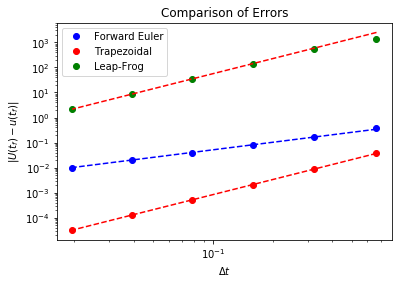

In [14]:
# Compare accuracy between Euler and Leap-Frog
f = lambda t, u: -u
u_exact = lambda t: numpy.exp(-t)
u_0 = 1.0

t_f = 10.0
num_steps = [2**n for n in range(4,10)]
delta_t = numpy.empty(len(num_steps))
error_euler = numpy.empty(len(num_steps))
error_trap = numpy.empty(len(num_steps))
error_leapfrog = numpy.empty(len(num_steps))

for (i, N) in enumerate(num_steps):
    t = numpy.linspace(0, t_f, N)
    delta_t[i] = t[1] - t[0]
    
    # Compute Euler solution
    u_euler = numpy.empty(t.shape)
    u_euler[0] = u_0
    for n in range(t.shape[0] - 1):
        u_euler[n+1] = u_euler[n] + delta_t[i] * f(t[n], u_euler[n])
        
    # Compute trapezoidal
    u_trap = numpy.empty(t.shape)
    u_trap[0] = u_0
    integration_constant = (1.0 - delta_t[i] / 2.0) / (1.0 + delta_t[i] / 2.0)
    for n in range(t.shape[0] - 1):
        u_trap[n + 1] = u_trap[n] * integration_constant
        
    # Compute Leap-Frog
    u_leapfrog = numpy.empty(t.shape)
    u_leapfrog[0] = 1.0
    u_leapfrog[1] = u_euler[1]
    for n in range(1, t.shape[0] - 1):
        u_leapfrog[n+1] = u_leapfrog[n-1] + 2.0 * delta_t[i] * f(t[n], u_leapfrog[n])
        
    # Compute error for each
    error_euler[i] = numpy.linalg.norm(delta_t[i] * (u_euler - u_exact(t)), ord=1)
    error_trap[i] = numpy.linalg.norm(delta_t[i] * (u_trap - u_exact(t)), ord=1)
    error_leapfrog[i] = numpy.linalg.norm(delta_t[i] * (u_leapfrog - u_exact(t)), ord=1)
    
# Plot error vs. delta_t
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
axes.loglog(delta_t, error_euler, 'bo', label='Forward Euler')
axes.loglog(delta_t, error_trap, 'ro', label='Trapezoidal')
axes.loglog(delta_t, error_leapfrog, 'go', label="Leap-Frog")

axes.loglog(delta_t, order_C(delta_t[2], error_euler[2], 1.0) * delta_t**1.0, '--b')
axes.loglog(delta_t, order_C(delta_t[2], error_trap[2], 2.0) * delta_t**2.0, '--r')
axes.loglog(delta_t, order_C(delta_t[2], error_leapfrog[2], 2.0) * delta_t**2.0, '--r')

axes.legend(loc=2)
axes.set_title("Comparison of Errors")
axes.set_xlabel("$\Delta t$")
axes.set_ylabel("$|U(t_f) - u(t_f)|$")

plt.show()